# <center> Projet : Cahier des charges </center>
#### <center> Algorithme et optimisation combinatoire</center>
###### <center> 15 Novembre 2024 </center>

Groupe 3 : </br>
* Arthur </br>
* Clément</br>
* Enzo </br>
* Théophile </br>
* Ylies </br>

### <center>Modélisation mathématique</center></br>
##### Modélisation mathématique pour VRP sans contraintes supplémentaires </br>
<u>Variables :</u>
* N $\to$ Nombre total de clients (villes).
* M $\to$ Nombre total de camions disponibles.
* Q $\to$ Capacité d'un camion type.
* $q_i \to $ Demande du client __i__.
* $d_{ij} \to $ Coût (distance ou temps) entre les clients $i$ et $j$.
* $x^{k}_{ij} /to$ Binaire :    
    * $x^{k}_{ij} = 1$ __si__ le camion __M__ se dirige vers un client __N__ / prends le chemin $(i,j)$</br>
    * $x^{k}_{ij}$ = 0 __sinon__
* $\alpha \to$ coefficient d'importance de la minimisation des distance
* $\beta \to$ coefficient d'importance de la minimisation du nombre de camion

<u>Objectif :</u>
Minimiser le coût total de la tournée </br></br>
$$z = \alpha \sum_{k=1}^{M} \sum_{i=0}^{N} \sum_{j=0}^{N} d_{ij} x_{ij}^{k}  + \beta \sum_{j=0}^N \sum_{a=0}^k x_{0j}^k$$

<u>Sous contraintes :</u>
1. Chaque client doit être visité qu'une seule et unique fois. </br>
$$ \sum_{k=1}^{N} \sum_{j=1}^{N} x_{ij}^{k} = 1 ; \forall i \in \{1;...;N\}$$
2. Flux entrant et sortant pour chaque véhicule. </br>
$$ \sum_{j=1}^{N} x_{ij}^{k} = \sum_{j=1}^{N} x_{ji}^{k} ; \forall i \in \{1;...;N\}, \forall k \in \{1;...;M\} $$
Si un véhicule __k__ arrive à un client, il doit quitter ce dernier vers un nouveau client __j__. </br></br>
3. Capacité du camion. 
$$ \sum_{i=1}^{N} q_i \sum_{j=1}^{N} x_{ij}^{k} \leq Q ; \forall k \in \{1;...;M\} $$
4. Tournée : Le camion part et revient au dépôt (indice 0).
$$ \sum_{i=1}^{N} x_{0j}^{k} = \sum_{j=1}^{N} x_{i0}^{k} = 1$$
5. Élimination des sous tournées (explication sur la photo Annexe). 
$$ u_i - u_j + N x_{ij}^{k} \leq N-1; \forall i,j \in \{1,...,N\}$$
Avec $u_i$ et $u_j$ étant des variables de flus correspond au numéro de l'ordre de visite du camion sur sa tournée. 

### <center> Création de solver pour le VRP </center>
##### Réalisation du solver exacte avec la bibliothèque PuLP

### <font color='red'> /!\ ATTENTION /!\ les résultats de l'agorithme de résolution avec la bibliothèque PuLP ne sont pas exacte du à la manière dont nous générons le bon nombre de camions </font>

In [1]:
import pulp
from matplotlib import pyplot as plt
from itertools import *
from data import *
from json import *
from Manip_JSON import *
from time import time
import random

t0 = time()
#-----------Résolution du problème avec pulp-----------#
def Solver_PuLP(q, d, Q):
    # Chargement des données
    somme_demande = sum(q.values())
    
    # Calcul du nombre de camions nécessaire
    M = 0
    while somme_demande > 0.75 * M * Q:
        M += 1

    # Obtenir la liste des villes
    villes = list(q.keys())
    N = len(villes) - 1  # Nombre de clients, sans compter le dépôt

    alpha = 1
    beta = 1

    # Création du problème
    vrp_problem = pulp.LpProblem("VRP", pulp.LpMinimize)

    # Variables de décision
    x = pulp.LpVariable.dicts("x", ((i, j, k) for i in range(len(d)) for j in range(len(d)) for k in range(M)), cat='Binary')
    u = pulp.LpVariable.dicts("u", (i for i in range(len(d))), lowBound=0, cat='Continuous')

    # Fonction objectif
    vrp_problem += (alpha * pulp.lpSum(d[i][j] * x[i, j, k] for i in range(len(d)) for j in range(len(d)) for k in range(M))
                    + beta * pulp.lpSum(x[0, j, k] for j in range(1, len(villes)) for k in range(M)))

    # Contraintes

    # 1. Chaque client doit être visité une fois
    for i in range(1, len(villes)):
        vrp_problem += pulp.lpSum(x[i, j, k] for j in range(len(villes)) for k in range(M) if i != j) == 1

    # 2. Conservation des flux pour chaque client et chaque camion
    for k in range(M):
        for i in range(1, len(villes)):
            vrp_problem += pulp.lpSum(x[i, j, k] for j in range(len(villes))) == pulp.lpSum(x[j, i, k] for j in range(len(villes)))

    # 3. Capacité des camions
    for k in range(M):
        vrp_problem += pulp.lpSum(q[villes[0]] * x[i, j, k] for i in range(1, len(villes)) for j in range(len(villes))) <= Q

    # 4. Dépôt visité une seule fois par chaque camion
    depot = villes[0]  # Supposons que le premier élément de `villes` est le dépôt
    for k in range(M):
        vrp_problem += pulp.lpSum(x[0, j, k] for j in range(1, len(villes))) == 1
        vrp_problem += pulp.lpSum(x[i, 0, k] for i in range(1, len(villes))) == 1

    # 5. Contrainte de sous-tour pour éviter les sous-tours (MTZ)
    for i in range(len(villes)):
        for j in range(len(villes)):
            if i != j:
                for k in range(M):
                    if i == 0:
                        u[i] = 0
                    elif j == 0:
                        u[j] = 0
                    else:
                        vrp_problem += u[i] - u[j] + N * x[i, j, k] <= N - 1

    # Résoudre le problème
    vrp_problem.solve()

    list_camion = []
    if pulp.LpStatus[vrp_problem.status] == "Optimal":
        solution = {}
        for i in range(len(villes)):
            for j in range(len(villes)):
                for k in range(M):
                    if x[i, j, k].value() is not None and x[i, j, k].value() > 0:
                        solution[(i, j, k)] = x[i, j, k].value()
        
        list_camion = [[] for _ in range(M)]
        for k in range(M):
            ville_actuelle = 0
            list_camion[k].append(ville_actuelle)
            while True:
                ville_prochaine = None
                for (i, j, p), val in solution.items():
                    if i == ville_actuelle and k == p and val > 0:
                        ville_prochaine = j
                        break
                if ville_prochaine is None or ville_prochaine == 0:
                    break
                list_camion[k].append(ville_prochaine)
                ville_actuelle = ville_prochaine
            list_camion[k].append(0)

        # Calcul de la distance totale
        distance = 0
        for k in range(M):
            for i in range(len(list_camion[k]) - 1):
                point_actuel = list_camion[k][i]
                point_futur = list_camion[k][i + 1]
                distance += d[point_actuel][point_futur]

    element_q = list(q.items())

    return k, list_camion, villes, M, element_q, distance

def plot_pulp(c,k,M):
    # Tracé des villes
    for ville, coord in c.items():
        plt.plot(coord[0], coord[1], 'o', markersize=10, label=ville if ville == '0' else "")
        plt.text(coord[0] + 0.1, coord[1] + 0.1, ville, fontsize=12)

    # Tracé des trajets par camion
    colors = ['b', 'g', 'r', 'c', 'm']
    for k in range(M):
        route = list_camion[k]
        for i in range(len(route) - 1):
            qepart = villes[route[i]]
            ville_arrivee = villes[route[i + 1]]
            x = [c[qepart][0], c[ville_arrivee][0]]
            y = [c[qepart][1], c[ville_arrivee][1]]
            plt.plot(x, y, colors[k % len(colors)], linewidth=2, label=f"Camion {k}" if i == 0 else "")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Itinéraires des camions entre les villes")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

random.seed(48)
result = generate()
if result:
    villes, distances_t = result

    nom_ville = list(villes)
    taille_groupe = len(villes) // 10  # Nombre de villes par groupe

    for i in range(10):
        # Déterminer les indices de début et de fin pour ce groupe
        debut = i * taille_groupe
        fin = debut + taille_groupe
            
        q = dict()
        for valeur in nom_ville[debut+1:fin+1]:
            q[valeur[0]] = random.randint(1, 10)
        premiere_cle = list(q.keys())[0]  # On récupère la première clé
        q[premiere_cle] = 0  # On met sa valeur à 
        
        indices = list(range(debut+1, fin+1))
        d = np.array(distances_t)[np.ix_(indices, indices)].tolist()  # Garder le nom distances

            
        k, list_camion, villes, M, element_q, Distance_totale = Solver_PuLP(q,d,50)
        list_nom_ville = []
        for p in range(len(list_camion)):
            list_nom_ville.append([])
            for j in range(len(list_camion[p])):
                list_nom_ville[p].append(villes[list_camion[p][j]])
        
        liste_ville = []
        
        
        Nom = "Pulp"
        
        
        for j in range(len(element_q)):
            liste_ville.append([element_q[j][0],element_q[j][1]])
        print(f"Resultats : \n Distance : {Distance_totale},\n Temps de réponse : {time()-t0},\n Nombre total de camion(s) : {k+1} ,\n Liste des trajets de tous les camions :{list_nom_ville}")
        Writer_JSON(liste_ville,i,time()-t0, Nom, k+1, list_nom_ville,Distance_totale, 'result.json')

Resultats : 
 Distance : 1983.2809475344964,
 Temps de réponse : 1.9819467067718506,
 Nombre total de camion(s) : 2 ,
 Liste des trajets de tous les camions :[['Maleville', 'Laroquebrou', 'Maleville'], ['Maleville', 'Saint-Martin-des-Champs', 'Chambray', 'Routot', 'Tremblois-lès-Rocroi', 'Prémanon', 'Berrias-et-Casteljau', 'Peyrolles', 'Mirepeisset', 'Maleville']]
Jeu de donnée généré
Données mises à jour
Resultats : 
 Distance : 2049.7530072716086,
 Temps de réponse : 2.5909461975097656,
 Nombre total de camion(s) : 2 ,
 Liste des trajets de tous les camions :[['Niaux', 'Rochecolombe', 'Seyssinet-Pariset', 'Monnet-la-Ville', 'Longwé', 'Écordal', 'Rians', 'Raymond', 'Noailles', 'Niaux'], ['Niaux', 'Lunac', 'Niaux']]
Jeu de donnée généré
Données mises à jour
Resultats : 
 Distance : 1836.6696839648384,
 Temps de réponse : 3.3504421710968018,
 Nombre total de camion(s) : 2 ,
 Liste des trajets de tous les camions :[['Saint-Marcel', 'La Vieille-Lyre', 'Saint-Marcel'], ['Saint-Marcel', 'Es

#### Réalisation du solver avec la métaheuristique Tabu

In [2]:

'''
 __/\\\\\\\\\\\\\\\_        _____/\\\\\\\\\____        __/\\\\\\\\\\\\\___        __/\\\________/\\\_        
  _\///////\\\/////__        ___/\\\\\\\\\\\\\__        _\/\\\/////////\\\_        _\/\\\_______\/\\\_       
   _______\/\\\_______        __/\\\/////////\\\_        _\/\\\_______\/\\\_        _\/\\\_______\/\\\_      
    _______\/\\\_______        _\/\\\_______\/\\\_        _\/\\\\\\\\\\\\\\__        _\/\\\_______\/\\\_     
     _______\/\\\_______        _\/\\\\\\\\\\\\\\\_        _\/\\\/////////\\\_        _\/\\\_______\/\\\_    
      _______\/\\\_______        _\/\\\/////////\\\_        _\/\\\_______\/\\\_        _\/\\\_______\/\\\_   
       _______\/\\\_______        _\/\\\_______\/\\\_        _\/\\\_______\/\\\_        _\//\\\______/\\\__  
        _______\/\\\_______        _\/\\\_______\/\\\_        _\/\\\\\\\\\\\\\/__        __\///\\\\\\\\\/___ 
         _______\///________        _\///________\///__        _\/////////////____        ____\/////////_____
'''

#----------------------------------------------------------------Importation des bibliothèques----------------------------------------------------------------

import random
from collections import deque
import time as tp
from tqdm import tqdm
from itertools import *
from data import *
import folium
from folium import plugins
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import requests
from Manip_JSON import *

#----------------------------------------------------------------Générateur d'instance----------------------------------------------------------------

random.seed(48)

#----------------------------------------------------------------Fonctions----------------------------------------------------------------

def generate_path(nb_villes):
    start_city = villes_liste[0]
    nb_camions = 0
    capacite = dict()
    route = dict()
    non_visite = villes_liste[1:]
    random.shuffle(non_visite)
    while non_visite:
        capacite[f"Camion n°{nb_camions + 1}"] = 0
        route[f"Camion n°{nb_camions + 1}"] = []
        route[f"Camion n°{nb_camions + 1}"].append(start_city)
        while capacite[f"Camion n°{nb_camions + 1}"] < capacite_max and non_visite:
            villes_possibles = []
            for i in non_visite:
                if capacite[f"Camion n°{nb_camions + 1}"] + ville_d[i] <= capacite_max:
                    villes_possibles.append(i)
            if not villes_possibles:
            # Aucune ville ne peut être ajoutée, on quitte la boucle interne
                break
            prochaine_ville = random.choice(villes_possibles)
            route[f"Camion n°{nb_camions + 1}"].append(prochaine_ville)
            non_visite.remove(prochaine_ville)
            capacite[f"Camion n°{nb_camions + 1}"] += ville_d[prochaine_ville]
        route[f"Camion n°{nb_camions + 1}"].append(start_city)
        nb_camions += 1
    return route


def calculate_path_distance(path, distance_matrix):
    total_distance = 0
    # Parcourir chaque camion dans le dictionnaire
    for camion_key in path.keys():
        route = path[camion_key]
        # Calculer la distance pour ce camion
        for i in range(len(route)-1):
            ville_depart = route[i]
            ville_arrivee = route[i + 1]
            # Convertir les noms de villes en indices pour la matrice de distance
            index_depart = villes_liste.index(ville_depart)
            index_arrivee = villes_liste.index(ville_arrivee)
            total_distance += distance_matrix[index_depart][index_arrivee]
    
    return total_distance

def calculate_weight(sol):
    poids = dict()
    for i in sol.keys():
        poids[i] = 0
        for j in sol[i]:
            poids[i] += ville_d[j]

    return poids


def generate_neighbors(path):
    neighbors = dict()
    # Pour chaque camion dans le chemin
    for k in range(len(path)):
        camion_key = f"Camion n°{k+1}"
        route = path[camion_key]
        # On ne considère que les villes intermédiaires (pas le dépôt)
        for i, j in combinations(range(1, len(route) - 1), 2):
            # On crée une copie du chemin initial
            neighbor = route[:]
            # On permute les villes
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            # On remplace la solution par les voisins
            path[camion_key] = neighbor
    
    return neighbors

def recherche_tabou(solution_initiale, taille_tabou, iter_max, matrix):
    nb_iter = 0                                                                
    liste_tabou = deque((), maxlen = taille_tabou)                             
                                                                               
    # variables solutions pour la recherche du voisin optimal non tabou        
    solution_courante = solution_initiale                                      
    meilleure = solution_initiale                                              
    meilleure_globale = solution_initiale                                       
                                                                               
    # variables valeurs pour la recherche du voisin optimal non tabou          
    valeur_meilleure = calculate_path_distance(solution_initiale, matrix)                       
    valeur_meilleure_globale = valeur_meilleure
    courantes = deque(()) 
    meilleures_courantes = deque(()) 

    while (nb_iter < iter_max):                                                
        valeur_meilleure = float('inf')    

        # On parcourt tous les voisins de la solution courante                
        for voisin in generate_neighbors(solution_courante).items():
            dico = solution_courante
            dico[voisin[0]] = voisin[1]
            valeur_voisin = calculate_path_distance(dico, matrix)
            poids_voisin = calculate_weight(dico)

            # On met à jour la meilleure solution non taboue trouvée                        
            if valeur_voisin < valeur_meilleure and voisin not in liste_tabou: 
                valeur_meilleure = valeur_voisin
                meilleure = voisin 
                                                             
                                                                               
        # On met à jour la meilleure solution rencontrée depuis le début       
        if valeur_meilleure < valeur_meilleure_globale:                    
            meilleure_globale = meilleure                                      
            valeur_meilleure_globale = valeur_meilleure  
            poids_meilleure_globale = 0
            nb_iter = 0     
        else:                                                                  
            nb_iter += 1

        courantes.append(calculate_path_distance(solution_courante, matrix)) 
        meilleures_courantes.append(valeur_meilleure_globale) 
                                                                                                              
        # on passe au meilleur voisin non tabou trouvé                         
        solution_courante = meilleure                                          
                                                                               
        # on met à jour la liste tabou                                         
        liste_tabou.append(solution_courante)                                  

    return meilleure_globale, courantes, meilleures_courantes

def multi_start(nb_villes, solution_initiale, distance_matrix, nb_test):
    taille_tabou = 100
    iter_max = 50

    # multi-start de n itérations
    val_max = float('inf')
    sol_max = None
    sac = solution_initiale
    solutions = []
    best_solutions = []

    for _ in tqdm(range(nb_test)):
        sol_courante, _, _ = recherche_tabou(sac, taille_tabou, iter_max, distance_matrix)
        val_courante = calculate_path_distance(sol_courante, distance_matrix)
        poids_courant = calculate_weight(sol_courante)

        solutions.append(val_courante)
        
        if val_courante < val_max:
            val_max = val_courante
            sol_max = sol_courante
            poids_max = poids_courant
        
        best_solutions.append(val_max)
        sac = generate_path(nb_villes)

    return sol_max, val_max, nb_test, solutions, best_solutions, poids_max

#---------------------------------------------------------------Main----------------------------------------------------------------
start = tp.time()
random.seed(48)
result = generate()
if result:
    villes, distances_t = result

    nom_ville = list(villes)
    taille_groupe = len(villes) // 10  # Nombre de villes par groupe

    for i in range(10):
        # Déterminer les indices de début et de fin pour ce groupe
        debut = i * taille_groupe
        fin = debut + taille_groupe

        ville_d = dict()
        for valeur in nom_ville[debut+1:fin+1]:
            ville_d[valeur[0]] = random.randint(1, 10)
        premiere_cle = list(ville_d.keys())[0]  # On récupère la première clé
        ville_d[premiere_cle] = 0  # On met sa valeur à
        
        indices = list(range(debut+1, fin+1))
        distances = np.array(distances_t)[np.ix_(indices, indices)].tolist()  # Garder le nom distances
        
        villes_liste = list(ville_d.keys())

        # Initialisation des paramètres
        nb_villes = len(villes_liste)
        capacite_max = 50
        taille_tabou = 500
        iter_max = 500 
        path = generate_path(nb_villes)
        solution_initiale = path

        # Run multi start
        nb_test = 2000
        sol_max, val_max, nb_test, solutions, best_solutions, poids = multi_start(nb_villes, solution_initiale, distances, nb_test)
        stop = tp.process_time()
        Nom = "Tabu"
        
        liste_ville = []
        print(f"Resultats : \n Distance : {val_max},\n Temps de réponse : {time()-t0},\n Nombre de camion : {len(sol_max)} \n Liste des trajets de tous les camions :{list(sol_max.values())}")
        Writer_JSON(liste_ville,i, tp.time()-start, Nom, len(sol_max), list(sol_max.values()),val_max,"result.json")
    

<>:1: SyntaxWarning: invalid escape sequence '\_'
<>:1: SyntaxWarning: invalid escape sequence '\_'
C:\Users\User\AppData\Local\Temp\ipykernel_25236\276827129.py:1: SyntaxWarning: invalid escape sequence '\_'
  '''
100%|██████████| 2000/2000 [00:01<00:00, 1832.59it/s]


Resultats : 
 Distance : 1996.2734252291582,
 Temps de réponse : 26.296375513076782,
 Nombre de camion : 1 
 Liste des trajets de tous les camions :[['Maleville', 'Laroquebrou', 'Chambray', 'Routot', 'Tremblois-lès-Rocroi', 'Saint-Martin-des-Champs', 'Prémanon', 'Berrias-et-Casteljau', 'Peyrolles', 'Mirepeisset', 'Maleville']]
Données mises à jour


100%|██████████| 2000/2000 [00:01<00:00, 1787.93it/s]


Resultats : 
 Distance : 2052.2646295061204,
 Temps de réponse : 27.42961072921753,
 Nombre de camion : 1 
 Liste des trajets de tous les camions :[['Niaux', 'Lunac', 'Seyssinet-Pariset', 'Monnet-la-Ville', 'Longwé', 'Écordal', 'Rians', 'Raymond', 'Noailles', 'Rochecolombe', 'Niaux']]
Données mises à jour


100%|██████████| 2000/2000 [00:01<00:00, 1542.91it/s]


Resultats : 
 Distance : 2131.3869414687388,
 Temps de réponse : 28.73869276046753,
 Nombre de camion : 1 
 Liste des trajets de tous les camions :[['Saint-Marcel', 'Essises', 'La Vieille-Lyre', 'Juignettes', 'Avenay', 'Fournets-Luisans', "L'Abergement-de-Varey", 'Fontanès', 'Saint-Mathieu-de-Tréviers', 'Tavant', 'Saint-Marcel']]
Données mises à jour


100%|██████████| 2000/2000 [00:01<00:00, 1447.03it/s]


Resultats : 
 Distance : 1846.257489298674,
 Temps de réponse : 30.136631965637207,
 Nombre de camion : 1 
 Liste des trajets de tous les camions :[['Beccas', 'Esplas-de-Sérou', 'Lissac', 'Courant', 'Montmarault', 'Belley', 'Trescléoux', 'Puy-Saint-André', 'Cabriès', 'Pech-Luna', 'Beccas']]
Données mises à jour


100%|██████████| 2000/2000 [00:01<00:00, 1488.37it/s]


Resultats : 
 Distance : 2570.5436716644804,
 Temps de réponse : 31.494312524795532,
 Nombre de camion : 1 
 Liste des trajets de tous les camions :[['Ladevèze-Rivière', 'Expiremont', 'Busserolles', 'Grandlup-et-Fay', 'Saint-Louet-sur-Seulles', 'Bavent', 'Pleyben', 'Vénérand', 'Creissan', 'Saint-André-de-Vézines', 'Ladevèze-Rivière']]
Données mises à jour


100%|██████████| 2000/2000 [00:01<00:00, 1652.56it/s]


Resultats : 
 Distance : 2455.0798410826055,
 Temps de réponse : 32.721235513687134,
 Nombre de camion : 1 
 Liste des trajets de tous les camions :[['Balaguier-sur-Rance', 'Le Temple', "Montagnac-d'Auberoche", 'Fatouville-Grestain', 'Braize', 'Le Châtelet', 'Oytier-Saint-Oblas', 'Loray', 'Saint-Jean-de-Moirans', 'La Palud-sur-Verdon', 'Balaguier-sur-Rance']]
Données mises à jour


100%|██████████| 2000/2000 [00:01<00:00, 1857.94it/s]


Resultats : 
 Distance : 3043.8467755361917,
 Temps de réponse : 33.813703298568726,
 Nombre de camion : 2 
 Liste des trajets de tous les camions :[['Sauve', 'Beaumont-sur-Lèze', 'Liesle', 'Les Hôpitaux-Neufs', 'Trouhans', 'Pure', 'Saint-Carné', 'Bourgnac', 'Marcheprime', 'Sauve'], ['Sauve', 'Manses', 'Sauve']]
Données mises à jour


100%|██████████| 2000/2000 [00:01<00:00, 1985.63it/s]


Resultats : 
 Distance : 2924.1382105268103,
 Temps de réponse : 34.833887577056885,
 Nombre de camion : 2 
 Liste des trajets de tous les camions :[['Le Fousseret', 'Belcastel', 'Peyriat', 'Chevagnes', 'Cernon', 'Meslières', 'Merey', 'Saint-Gildas', 'Saint-Germain-des-Prés', 'Le Fousseret'], ['Le Fousseret', 'Védrines-Saint-Loup', 'Le Fousseret']]
Données mises à jour


100%|██████████| 2000/2000 [00:00<00:00, 2180.12it/s]


Resultats : 
 Distance : 2792.299817305009,
 Temps de réponse : 35.76503229141235,
 Nombre de camion : 2 
 Liste des trajets de tous les camions :[['Santosse', 'Beaumont-en-Véron', 'Bieujac', 'Le Taillan-Médoc', 'Auriac', 'Mons', 'Saint-Pierre-de-Mésage', 'La Brigue', 'Santosse'], ['Santosse', 'Houville-la-Branche', 'Véretz', 'Santosse']]
Données mises à jour


100%|██████████| 2000/2000 [00:01<00:00, 1870.76it/s]

Resultats : 
 Distance : 2466.5584079329437,
 Temps de réponse : 36.847426652908325,
 Nombre de camion : 1 
 Liste des trajets de tous les camions :[['Maël-Pestivien', 'Guengat', 'Vernais', 'Marcigny-sous-Thil', "Plateau d'Hauteville", 'Saint-Rustice', 'Lapège', 'Montgaillard', 'Saint-Paul-et-Valmalle', 'Saint-Martin-du-Bois', 'Maël-Pestivien']]
Données mises à jour


#### Réalisation du solver basé sur un algorithme de colonie de foumie 

In [3]:
#   _____      _             _            _         __                           _     
#  / ____|    | |           (_)          | |       / _|                         (_)    
# | |     ___ | | ___  _ __  _  ___    __| | ___  | |_ ___  _   _ _ __ _ __ ___  _ ___ 
# | |    / _ \| |/ _ \| '_ \| |/ _ \  / _` |/ _ \ |  _/ _ \| | | | '__| '_ ` _ \| / __|
# | |___| (_) | | (_) | | | | |  __/ | (_| |  __/ | || (_) | |_| | |  | | | | | | \__ \
# \_____\___/|_|\___/|_| |_|_|\___|  \__,_|\___| |_| \___/ \__,_|_|  |_| |_| |_|_|___/

# Métaheuristique : Colonie de fourmis
# À base de population - Intelligence en essaim

# Importation des bibliothèques
import random
import numpy as np
from data import *
import time as tp
import folium
from folium import plugins
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.distance import geodesic
import requests
from Manip_JSON import * 

# Temps départ
t0 = tp.time()

# Variables globales des fourmis
nb_fourmis = 200
max_iteration = 5000

t_evaporation = 0.1 # Taux d'évaporation
i_phero, i_visi, depot_phero = 1, 2, 100  # Importance des phéromones, visibilité et dépôt

# Variables globales des camions
capacite_max = 50

# Cache pour les probabilités
cache_probabilites = {}

# Fonction pour construire une solution
def construire_solution():
    non_visite = list(ville_d.keys())[1:] # On crée un ensemble de données avec les numéros des villes
    routes = dict() # Liste de toutes les routes de tous les camions
    capacite = dict() # Pour la capacité de chaque camion
    distance_total = 0
    nb_camions = 0
    depot = list(ville_d.keys())[0]  # Convertir les clés en liste et accéder à la première clé

    # Assigner des villes aux camions
    while non_visite:
        ville_actuel = depot # On démarre forcément au dépôt
        routes[f"Camion n{nb_camions + 1}"] = [] # On fait la route pour un seul camion
        routes[f"Camion n{nb_camions + 1}"].append(depot)
        capacite[f"Camion n{nb_camions + 1}"] = 0

        while capacite[f"Camion n{nb_camions + 1}"] < capacite_max and non_visite:
            # Vérifie si au moins une ville peut être ajoutée sans dépasser la capacité maximale
            villes_possibles = [v for v in non_visite if (capacite[f"Camion n{nb_camions + 1}"] + ville_d[v]) <= capacite_max]
            if not villes_possibles:
                # Aucune ville ne peut être ajoutée, on quitte la boucle interne
                break
            
            # Calculer les probabilités pour les chemins vers les villes possibles
            probabilites = dict()
            for prochaine_ville in villes_possibles:
                # Vérification du cache pour les probabilités
                if (ville_actuel, prochaine_ville) in cache_probabilites:
                    probabilite = cache_probabilites[(ville_actuel, prochaine_ville)]
                else:
                    if ville_actuel is not non_visite:
                        pheromone = v_phero[0][non_visite.index(prochaine_ville) + 1]
                        visibilité = visibilites[0][non_visite.index(prochaine_ville) + 1]
                    else:
                        pheromone = v_phero[non_visite.index(ville_actuel) + 1][non_visite.index(prochaine_ville) + 1]
                        visibilité = visibilites[non_visite.index(ville_actuel) + 1][non_visite.index(prochaine_ville) + 1]
                    probabilite = (pheromone ** i_phero) * (visibilité ** i_visi)
                    cache_probabilites[(ville_actuel, prochaine_ville)] = probabilite
                
                probabilites[prochaine_ville] = probabilite
            
            # Sélection de la prochaine ville
            total_proba = sum(probabilites.values())
            if total_proba == 0:
                prochaine_ville = random.choice(villes_possibles)
            else:
                probabilites = {v: prob / total_proba for v, prob in probabilites.items()}
                prochaine_ville = random.choices(
                    population=[v for v, _ in probabilites.items()],
                    weights=[prob for _, prob in probabilites.items()]
                )[0]

            # Mettre à jour la route et la capacité du camion si la ville est ajoutée
            routes[f"Camion n{nb_camions + 1}"].append(prochaine_ville)
            non_visite.remove(prochaine_ville)
            distance_total += distances[villes_liste.index(ville_actuel)][villes_liste.index(prochaine_ville)]
            capacite[f"Camion n{nb_camions + 1}"] += ville_d[prochaine_ville]
            ville_actuel = prochaine_ville # Mise à jour de la ville actuelle

        # Retour au dépôt
        distance_total += distances[villes_liste.index(ville_actuel)][0]
        routes[f"Camion n{nb_camions + 1}"].append(depot)
        nb_camions += 1

    return routes, capacite, distance_total

def maj_pheromones(solutions, v_pheromone):
    # Évaporation des phéromones
    v_pheromone *= (1 - t_evaporation)

    # Dépôt de nouvelles phéromones pour chaque solution
    for solution in solutions:
        # Solution est un tuple (routes, distance_total)
        routes, distance_total = solution

        # Calcul du dépôt de phéromones pour cette solution
        deposit = depot_phero / distance_total

        # Parcours des itinéraires de chaque camion
        for camion, vehicule_route in routes.items():
            ville_actuel = 0 # Index du dépôt (Nancy)
            
            # On ignore la première et la dernière ville (les deux "Nancy")
            for prochaine_ville_nom in vehicule_route[1:-1]:
                prochaine_ville = villes_liste.index(prochaine_ville_nom) # Index de la prochaine ville
                v_pheromone[ville_actuel][prochaine_ville] += deposit
                ville_actuel = prochaine_ville

            # Retour au dépôt (Nancy)
            v_pheromone[ville_actuel][ville_actuel] += deposit

    return v_pheromone

def resoudre(v_pheromone, meilleur_distance, meilleur_solution, meilleur_capacite):
    for iteration in range(max_iteration):
        # Solutions construites par les fourmis
        solutions = []
        for i in range(nb_fourmis):
            routes, capacite, distance_total = construire_solution()

            # Mise à jour de la meilleure solution
            if distance_total < meilleur_distance:
                meilleur_distance = distance_total
                meilleur_solution = routes
                meilleur_capacite = capacite
            
        # Mise à jour des phéromones
        v_pheromone = maj_pheromones(solutions, v_pheromone)

    return meilleur_solution, meilleur_capacite, meilleur_distance

def main():

    global nom_ville, ville_d, v_phero, visibilites, distances, villes_liste

    # Seed
    random.seed(48)

    # Lecture des données
    result = generate()
    if result:
        villes, distances_t = result

        # Liste des noms de villes
        nom_ville = list(villes)
        taille_groupe = len(villes) // 10  # Nombre de villes par groupe

        for i in range(10):
            # Déterminer les indices de début et de fin pour ce groupe
            debut = i * taille_groupe
            fin = debut + taille_groupe

            ville_d = dict()
            for valeur in nom_ville[debut+1:fin+1]:
                ville_d[valeur[0]] = random.randint(1, 10)
            premiere_cle = list(ville_d.keys())[0]  # On récupère la première clé
            ville_d[premiere_cle] = 0  # On met sa valeur à 0
            
            # Récupère la première clé pour définir le dépôt
            villes_liste = list(ville_d.keys())

            # Extraire la sous-matrice de distances pour ce groupe
            indices = list(range(debut+1, fin+1))
            distances = np.array(distances_t)[np.ix_(indices, indices)].tolist()  # Garder le nom distances

            # Nombre de villes dans le groupe actuel
            n = len(ville_d)
            
            # Initialisation des phéromones et des visibilites
            v_phero = np.ones((n, n), dtype=float) - np.eye(n)  # Initialisation des phéromones
            distance_matrix = np.array(distances)  # Conversion pour manipulation avec numpy
            visibilites = 1 / (distance_matrix + np.eye(n))  # Calcul de la visibilité

            # Initialisation des solutions
            meilleur_solution, meilleur_distance, meilleur_capacite = None, float('inf'), None

            # Résoudre le problème pour ce groupe (appelle ta fonction resoudre)
            t0 = tp.time()  # Temps de départ
            solution, capacite, distance = resoudre(v_phero, meilleur_distance, meilleur_solution, meilleur_capacite)
            tf = tp.time()  # Temps de fin
            tt = tf - t0  # Temps total pour résoudre

            # Nom de la solution pour l'enregistrement
            Nom = "ANT"
            valeur = []
            for _, values in solution.items():
                valeur.append(values)

            # Écriture du résultat dans le fichier JSON (appel de ta fonction Writer_JSON)
            print(f"Resultats : \n Distance : {distance},\n Temps de réponse : {tt},\n Nombre de camion : {len(capacite)} \n Liste des trajets de tous les camions :{valeur}")
            Writer_JSON(nom_ville[i * taille_groupe:(i + 1) * taille_groupe], i, tt, Nom, len(capacite), valeur, distance, 'result.json')

main()


Resultats : 
 Distance : 1855.3293941668444,
 Temps de réponse : 58.734920024871826,
 Nombre de camion : 1 
 Liste des trajets de tous les camions :[['Maleville', 'Laroquebrou', 'Saint-Martin-des-Champs', 'Chambray', 'Routot', 'Tremblois-lès-Rocroi', 'Prémanon', 'Berrias-et-Casteljau', 'Peyrolles', 'Mirepeisset', 'Maleville']]
Données mises à jour
Resultats : 
 Distance : 1738.4884143766756,
 Temps de réponse : 59.029736042022705,
 Nombre de camion : 1 
 Liste des trajets de tous les camions :[['Niaux', 'Lunac', 'Noailles', 'Raymond', 'Rians', 'Écordal', 'Longwé', 'Monnet-la-Ville', 'Seyssinet-Pariset', 'Rochecolombe', 'Niaux']]
Données mises à jour
Resultats : 
 Distance : 1731.5027861815638,
 Temps de réponse : 57.583967208862305,
 Nombre de camion : 1 
 Liste des trajets de tous les camions :[['Saint-Marcel', 'La Vieille-Lyre', 'Juignettes', 'Avenay', 'Tavant', 'Saint-Mathieu-de-Tréviers', 'Fontanès', "L'Abergement-de-Varey", 'Fournets-Luisans', 'Essises', 'Saint-Marcel']]
Données m

#### Réalisation du solver basé sur l'algorithme génétique 

In [ ]:
import random
import math
import json
import numpy as np
from typing import List, Dict
import folium
from sklearn.cluster import KMeans
import colorsys  # Importation du module colorsys pour la génération de couleurs uniques

# Classe City représentant une ville avec nom, coordonnées GPS, nombre de colis et demande totale
class City:
    def __init__(self, index: int, name: str, lat: float, lon: float, demand: int):
        self.index = index
        self.name = name
        self.lat = lat
        self.lon = lon
        self.demand = demand  # Demande en unités (poids, volume, etc.)

# Fonction pour calculer la distance entre deux villes (formule de Haversine)
def calculate_distance(city1: City, city2: City) -> float:
    R = 6371  # Rayon de la Terre en km
    lat1_rad = math.radians(city1.lat)
    lat2_rad = math.radians(city2.lat)
    delta_lat = lat2_rad - lat1_rad
    delta_lon = math.radians(city2.lon - city1.lon)

    a = math.sin(delta_lat / 2) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# Fonction pour lire les villes à partir d'un fichier JSON
def read_cities_from_json(filename: str) -> List[City]:
    cities = []
    try:
        with open(filename, 'r', encoding='utf-8') as jsonfile:
            data = json.load(jsonfile)
            for idx, item in enumerate(data['cities']):
                try:
                    name = item['label']
                    lat_str = item['latitude']
                    lon_str = item['longitude']
                    if lat_str == '' or lon_str == '':
                        continue  # Ignorer cette ville
                    lat = float(lat_str)
                    lon = float(lon_str)
                    demand = 0  # La demande sera définie plus tard
                    cities.append(City(idx + 1, name, lat, lon, demand))
                except ValueError:
                    continue  # Ignorer cette ville
        return cities
    except FileNotFoundError:
        print(f"Le fichier {filename} n'a pas été trouvé.")
        return []
    except KeyError as e:
        print(f"Clé manquante dans le fichier JSON : {e}")
        return []
    except json.JSONDecodeError:
        print("Erreur lors du décodage du fichier JSON.")
        return []

# Fonction pour générer des demandes aléatoires pour les villes
def generate_random_demands(cities: List[City], min_demand: int = 1, max_demand: int = 10):
    for city in cities:
        city.demand = random.randint(min_demand, max_demand)

# Fonction pour calculer la matrice des distances
def calculate_distance_matrix(cities: List[City]) -> np.ndarray:
    num_cities = len(cities)
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(i, num_cities):
            dist = calculate_distance(cities[i], cities[j])
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist
    return distance_matrix

# Fonction de clustering K-Means capacitaire
def kmeans_capacitated_clustering(cities: List[City], vehicle_capacity: int) -> List[List[City]]:
    # Calcul du nombre minimal de camions nécessaires
    total_demand = sum(city.demand for city in cities)
    num_clusters = math.ceil(total_demand / vehicle_capacity)

    # Initialisation du clustering
    coordinates = np.array([[city.lat, city.lon] for city in cities])
    demands = np.array([city.demand for city in cities])

    # Clustering initial avec K-Means
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coordinates)
    labels = kmeans.labels_

    # Création des clusters avec les villes et leurs demandes
    clusters = [[] for _ in range(num_clusters)]
    cluster_demands = [0] * num_clusters
    for idx, city in enumerate(cities):
        cluster_idx = labels[idx]
        clusters[cluster_idx].append(city)
        cluster_demands[cluster_idx] += city.demand

    # Ajustement des clusters pour respecter les capacités
    adjusted = True
    while adjusted:
        adjusted = False
        for i in range(num_clusters):
            while cluster_demands[i] > vehicle_capacity:
                # Trouver la ville la plus éloignée du centre du cluster
                center = kmeans.cluster_centers_[i]
                furthest_city = max(clusters[i], key=lambda c: math.hypot(c.lat - center[0], c.lon - center[1]))
                clusters[i].remove(furthest_city)
                cluster_demands[i] -= furthest_city.demand

                # Trouver un nouveau cluster pour cette ville
                # Affecter au cluster le plus proche qui peut l'accueillir
                min_distance = float('inf')
                best_cluster = -1
                for j in range(num_clusters):
                    if i != j and cluster_demands[j] + furthest_city.demand <= vehicle_capacity:
                        center_j = kmeans.cluster_centers_[j]
                        distance = math.hypot(furthest_city.lat - center_j[0], furthest_city.lon - center_j[1])
                        if distance < min_distance:
                            min_distance = distance
                            best_cluster = j
                if best_cluster == -1:
                    # Si aucun cluster ne peut l'accueillir, il faut augmenter le nombre de clusters
                    num_clusters += 1
                    clusters.append([])
                    cluster_demands.append(0)
                    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(coordinates)
                    labels = kmeans.labels_
                    adjusted = True
                    break  # Recommencer l'ajustement avec le nouveau nombre de clusters
                else:
                    clusters[best_cluster].append(furthest_city)
                    cluster_demands[best_cluster] += furthest_city.demand
                    adjusted = True
    return clusters

# Création de la population initiale pour l'algorithme génétique
def create_initial_population(city_indices: List[int], population_size: int) -> List[List[int]]:
    num_cities = len(city_indices)
    population = []
    for _ in range(population_size):
        individual = city_indices[:]
        random.shuffle(individual)
        population.append(individual)
    return population

# Fonction pour évaluer la fitness d'un individu (distance totale du trajet)
def fitness_function(individual: List[int], distance_matrix: np.ndarray) -> float:
    total_distance = 0
    current_city = 0  # Index du dépôt
    for city_idx in individual:
        total_distance += distance_matrix[current_city][city_idx]
        current_city = city_idx
    # Retour au dépôt après la dernière ville
    total_distance += distance_matrix[current_city][0]
    return total_distance

# Sélection par tournoi pour l'algorithme génétique
def selection(population: List[List[int]], fitnesses: List[float], num_selected: int) -> List[List[int]]:
    selected = []
    population_with_fitness = list(zip(population, fitnesses))
    pop_size = len(population_with_fitness)
    tournament_size = min(5, pop_size)
    for _ in range(num_selected):
        participants = random.sample(population_with_fitness, k=tournament_size)
        winner = min(participants, key=lambda x: x[1])
        selected.append(winner[0])
    return selected

# Croisement PMX pour l'algorithme génétique
def crossover(parent1: List[int], parent2: List[int]) -> List[int]:
    size = len(parent1)
    child = [None]*size
    start, end = sorted(random.sample(range(size), 2))
    child[start:end] = parent1[start:end]
    for idx in range(size):
        if child[idx] is None:
            gene = parent2[idx]
            while gene in child:
                gene = parent2[parent1.index(gene)]
            child[idx] = gene
    return child

# Mutation par inversion pour l'algorithme génétique
def mutate(individual: List[int], mutation_rate: float) -> List[int]:
    num_mutations = max(1, int(len(individual) * mutation_rate))
    for _ in range(num_mutations):
        start, end = sorted(random.sample(range(len(individual)), 2))
        individual[start:end] = reversed(individual[start:end])
    return individual

# Algorithme génétique pour résoudre le TSP pour chaque camion
def genetic_algorithm_tsp(cities: List[City], depot: City, generations=1000, population_size=500, mutation_rate=0.4) -> Dict:
    all_cities = [depot] + cities
    num_cities = len(all_cities)
    city_indices = list(range(1, num_cities))  # Exclure le dépôt

    # Ajuster la taille de la population si nécessaire
    max_permutations = math.factorial(len(city_indices))
    if population_size > max_permutations:
        population_size = max_permutations

    population = create_initial_population(city_indices, population_size)
    distance_matrix = calculate_distance_matrix(all_cities)

    best_individual = None
    best_fitness = float('inf')
    no_improvement = 0
    max_no_improvement = 100

    for generation in range(generations):
        fitnesses = [fitness_function(individual, distance_matrix) for individual in population]

        current_best_fitness = min(fitnesses)
        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_individual = population[fitnesses.index(best_fitness)].copy()
            no_improvement = 0
            print(f"Génération {generation}: Nouvelle meilleure solution avec distance = {best_fitness:.2f} km")
        else:
            no_improvement += 1

        if no_improvement >= max_no_improvement:
            print("Arrêt précoce : aucune amélioration observée au cours des dernières générations.")
            break

        selected = selection(population, fitnesses, population_size)
        new_population = []
        while len(new_population) < population_size:
            parents = random.sample(selected, min(2, len(selected)))
            child = crossover(parents[0], parents[1]) if len(parents) == 2 else parents[0][:]
            child = mutate(child, mutation_rate)
            new_population.append(child)
        population = new_population

    route = best_individual
    total_distance = best_fitness

    return {
        'route': route,
        'distance': total_distance,
        'distance_matrix': distance_matrix,
        'all_cities': all_cities
    }

# Fonction pour afficher la solution
def print_solution(depot: City, result: Dict, truck_number: int, vehicle_capacity: int):
    route = result['route']
    distance = result['distance']
    distance_matrix = result['distance_matrix']
    all_cities = result['all_cities']

    route_demand = sum(all_cities[city_idx].demand for city_idx in route)

    print(f"\n🚛 Camion {truck_number} :")
    print(f"Charge totale : {route_demand}/{vehicle_capacity} unités")
    print(f"Départ du dépôt ({depot.name})")

    current_city = 0  # Dépôt
    for city_idx in route:
        next_city = all_cities[city_idx]
        distance_segment = distance_matrix[current_city][city_idx]
        print(f" - {next_city.name} (Demande : {next_city.demand} unités, Distance depuis {all_cities[current_city].name} : {distance_segment:.2f} km)")
        current_city = city_idx

    # Retour au dépôt
    distance_to_depot = distance_matrix[current_city][0]
    print(f"Retour au dépôt ({depot.name}) avec une distance de {distance_to_depot:.2f} km")
    print(f"Distance totale pour Camion {truck_number} : {distance:.2f} km")

# Fonction pour créer la carte avec folium
def create_map(depot: City, results: List[Dict]):
    map_center = [depot.lat, depot.lon]
    folium_map = folium.Map(location=map_center, zoom_start=6)

    # Marquer le dépôt
    folium.Marker(
        [depot.lat, depot.lon],
        popup=f"Dépôt ({depot.name})",
        icon=folium.Icon(color='red', icon='home')
    ).add_to(folium_map)

    # Générer des couleurs uniques pour chaque camion
    def generate_unique_colors(n):
        colors = []
        for i in range(n):
            hue = i / n
            lightness = 0.5
            saturation = 0.9
            rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
            hex_color = '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
            colors.append(hex_color)
        return colors

    num_trucks = len(results)
    colors = generate_unique_colors(num_trucks)

    for idx, result in enumerate(results):
        route = result['route']
        all_cities = result['all_cities']
        color = colors[idx]

        route_points = [[depot.lat, depot.lon]]
        for city_idx in route:
            city = all_cities[city_idx]
            folium.Marker(
                [city.lat, city.lon],
                popup=f"{city.name} (Demande : {city.demand} unités)",
                icon=folium.Icon(color='blue', icon_color=color)
            ).add_to(folium_map)
            route_points.append([city.lat, city.lon])
        route_points.append([depot.lat, depot.lon])
        folium.PolyLine(route_points, color=color, weight=2.5, opacity=0.8).add_to(folium_map)

    folium_map.save("vrp_solution_map.html")
    print("La carte a été sauvegardée sous le nom 'vrp_solution_map.html'.")

def main():
    try:
        # Lecture des villes depuis le fichier JSON
        all_cities = read_cities_from_json('cities.json')

        if not all_cities:
            print("Aucune ville n'a été chargée. Vérifiez le fichier JSON.")
            return

        # Demander le nombre de villes à utiliser
        total_cities = len(all_cities)
        min_cities = 1
        while True:
            try:
                num_cities = int(input(f"Entrez le nombre de villes à utiliser ({min_cities}-{total_cities}) : "))
                if min_cities <= num_cities <= total_cities:
                    break
                else:
                    print(f"Veuillez entrer un nombre entre {min_cities} et {total_cities}.")
            except ValueError:
                print("Veuillez entrer un nombre entier.")

        # Sélectionner aléatoirement les villes
        selected_cities = random.sample(all_cities, num_cities)

        # Définir le dépôt
        depot = City(0, "Paris", 48.8566, 2.3522, 0)

        # Générer des demandes aléatoires
        generate_random_demands(selected_cities, min_demand=1, max_demand=10)

        # Demander la capacité du véhicule
        while True:
            try:
                vehicle_capacity_input = 50
                vehicle_capacity = int(vehicle_capacity_input) if vehicle_capacity_input else 100
                if vehicle_capacity > 0:
                    break
                else:
                    print("La capacité du véhicule doit être un nombre positif.")
            except ValueError:
                print("Veuillez entrer un nombre entier.")

        # Calcul du nombre minimal de camions nécessaires
        total_demand = sum(city.demand for city in selected_cities)
        num_trucks = math.ceil(total_demand / vehicle_capacity)
        print(f"\nNombre total de camions nécessaires : {num_trucks}")

        # Clustering K-Means capacitaire
        clusters = kmeans_capacitated_clustering(selected_cities, vehicle_capacity)

        # Vérifier que chaque cluster respecte la capacité
        for idx, cluster in enumerate(clusters):
            total_cluster_demand = sum(city.demand for city in cluster)
            print(f"Cluster {idx + 1}: Charge totale {total_cluster_demand}/{vehicle_capacity} unités")

        # Exécuter l'algorithme génétique pour chaque cluster
        results = []
        for i, cluster in enumerate(clusters):
            print(f"\nOptimisation de l'itinéraire pour le Camion {i + 1}...")
            result = genetic_algorithm_tsp(cluster, depot, generations=500, population_size=100, mutation_rate=0.4)
            results.append(result)

        # Afficher les résultats pour chaque camion
        for i, result in enumerate(results):
            print_solution(depot, result, i + 1, vehicle_capacity)

        # Créer et sauvegarder la carte avec la solution trouvée
        create_map(depot, results)

    except ValueError as e:
        print(e)

if __name__ == "__main__":
    main()



Nombre total de camions nécessaires : 12
Cluster 1: Charge totale 50/50 unités
Cluster 2: Charge totale 42/50 unités
Cluster 3: Charge totale 50/50 unités
Cluster 4: Charge totale 49/50 unités
Cluster 5: Charge totale 50/50 unités
Cluster 6: Charge totale 49/50 unités
Cluster 7: Charge totale 48/50 unités
Cluster 8: Charge totale 48/50 unités
Cluster 9: Charge totale 48/50 unités
Cluster 10: Charge totale 49/50 unités
Cluster 11: Charge totale 43/50 unités
Cluster 12: Charge totale 47/50 unités
Cluster 13: Charge totale 0/50 unités

Optimisation de l'itinéraire pour le Camion 1...
Génération 0: Nouvelle meilleure solution avec distance = 1755.56 km
Génération 1: Nouvelle meilleure solution avec distance = 1586.92 km
Génération 2: Nouvelle meilleure solution avec distance = 1481.77 km
Génération 3: Nouvelle meilleure solution avec distance = 1436.99 km
Génération 4: Nouvelle meilleure solution avec distance = 1434.38 km
Génération 6: Nouvelle meilleure solution avec distance = 1418.30 

### <center> Réalisation du plan d'expérience </center>
#### Étape 1 définir l'objectif : 
-   Minimiser le temps de réponse du programme, augmenter la précision de l'algorithme utilisé par rapport à la solution exacte. 

#### Éetape 2 Identifier les facteurs : 
-   Le paramétrage des algorithmes 
-   L'algorithme utilisé 
-   La machine exécutant le code ( s'il y a beaucoup d'autres programmes utilisé à côté ou non et les performances générales de ma machine)

#### Étape 3 réaliser l'expériance :
-   Chaque algorithme de réalisation devra réalisier 1 fois 10 jeux de données de 10 villes différents (qui seront les mêmes entre les algorithmes)
-   Chaque algorithme de réalisation devra réaliser 10 fois 100 villes différentes (qui seront les mêmes entre les algorithmes) en faisant varier les paramètres 
-   Les résultats seront en suite inscrit dans des fichiers result_(nom_meta).json qui permettra de mutualiser toutes les données 
-   A partir des données présentes dans les fichier JSON, nous réaliserons les graphiques suivants :
    *   Graphique en barre avec en abscisse le jeu de données et en ordonnée le temps d'exécution du programe
    *   Graphique en barre avec en abcsisse l'algoritme de résolution et en ordonnée sa proximité avec la solution exacte
    *   Boites à moustaches pour comparer les temps d'exécution et les distances totales renvoyé par le même algorithme en fonction de ses paramètres
    *   Graphique de comparaison de la variatoin des résultats pour chaque algorithme en fonction de leurs paramètres 


### <center>Réalisation de l'expérience </center>

#### Bibliothèque que nous avons créé 
##### Manip_JSON.py

Ce fichier nous permettra d'écrire les différentes données des différents algorithmes de résolution pour réaliser nos statistiques.


In [5]:
from json import *

# Fonction pour écrire dans le fichier JSON
def Writer_JSON(Liste_ville,Num_Jeu,tps, Nom_Algo, Nombre_Camion, Liste_Trajet,km, JSON_Path):
    
    # Ouverture du fichier JSON 
    with open(JSON_Path, "r+") as file:
        # on vérifie si l'on exécute l'algorithme PuLP 
        if Nom_Algo == "Pulp":
            # on prépare ce à quoi va ressembler le jeux de données dans le fichier JSON
            test = {
                "villes":Liste_ville, 
                Nom_Algo:{
                    "NombreCamion":Nombre_Camion,
                    "Distance":km,
                    "Temps":tps,
                    "ListeTrajet":Liste_Trajet
                }
            }
            
            # on essaye de lire les données déjà présentes dans le fichier 
            try :
                data = load(file)
            
            # Si le fichier JSON est vide alors on initialise le contenu 
            except JSONDecodeError:
                data={}
            # on mets à jours les données du jeu dont le numéro a été donné au dessu en paramètre de la fonction 
            data["Jeu_"+str(Num_Jeu)]= test
            
            file.seek(0)
            dump(data,file, indent=4)
            file.truncate()
        
        else:
            try:
                data = load(file)
            except JSONDecodeError:
                data={}
            # on se prépare à ajouter les valeurs de l'algorithme 
            test = {
                    "NombreCamion" : Nombre_Camion,
                    "Distance": km,
                    "Temps" : tps,
                    "ListeTrajet" : Liste_Trajet
                }
            
            data["Jeu_"+str(Num_Jeu)][Nom_Algo] = test
            file.seek(0)
            dump(data, file, indent=4)
            file.truncate()
            
    print("Données mises à jour")

def STAT_JSON(Liste_ville,Num_Jeu,tps, Nom_Algo, Nombre_Camion, Liste_Trajet,km, JSON_Path):
    with open(JSON_Path, "r+") as file:
        test = {
            "villes":Liste_ville, 
            Nom_Algo:{
            "NombreCamion":Nombre_Camion,
            "Distance":km,
            "Temps":tps,
            "ListeTrajet":Liste_Trajet
            }
        }
        try :
            data = load(file)
        except JSONDecodeError:
            data={}
        print("Mise à jour réussie")
        data[str(Num_Jeu)]= test
        file.seek(0)
        dump(data,file, indent=4)
        file.truncate()

#### Comparaison entre le solver pulp et les métaheuristiques

Pour cette statistiques nous comparons la distance final et le temps d'exécution renvoyé par le solver pulp pour 10 jeux de 10 villes, avec les mêmes pour deux de nos trois métaheuristiques.

(Nous n'avons malheuresement pas réussi à implémenter l'algorithme génétique à cette statistique, nous avons des problèmes avec notre jeux de données que nous avons du modifier de dernière minute) 

Pour cette partie nous allons lire les données inscrit dans le fichier "result.json" (voir dépôt git en annexe dans le dossier statistique). Pour ce qui est des graphiques ce sera ceci :
*   Graphique en barre avec en abscisse le jeu de données et en ordonnée le temps d'exécution du programe
*   Graphique en barre avec en abcsisse l'algoritme de résolution et en ordonnée sa proximité avec la solution exacte

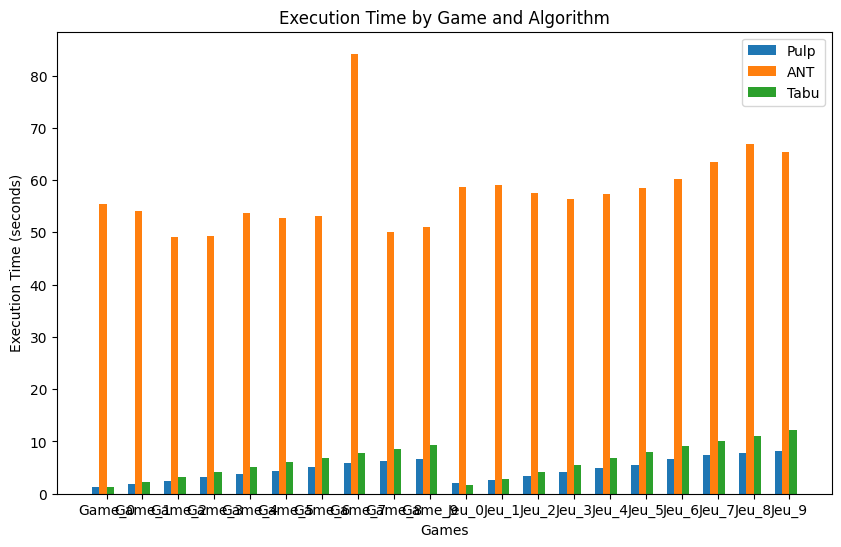

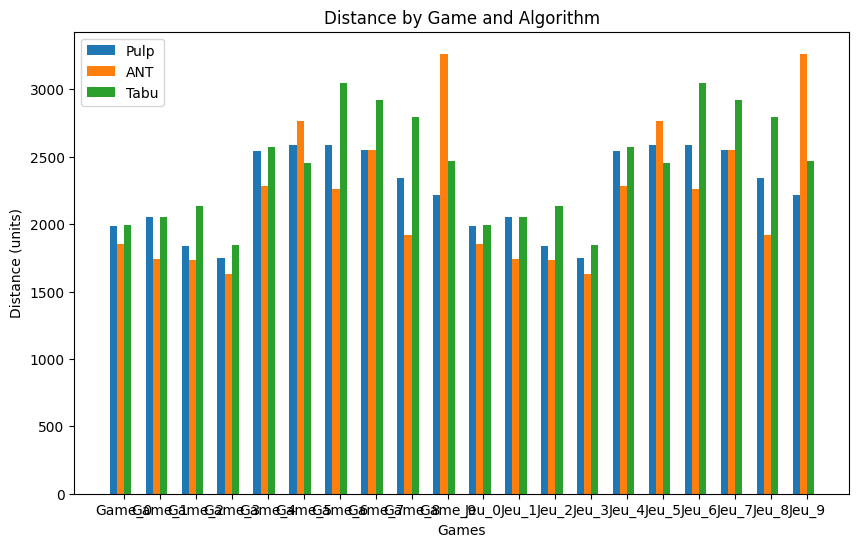

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Chargement des données JSON
with open("result.json", "r") as file:
    data = json.load(file)

# Initialiser des listes pour stocker les valeurs
jeux = []
algorithmes = ["Pulp", "ANT", "Tabu"]
temps_execution = {algo: [] for algo in algorithmes}
distances = {algo: [] for algo in algorithmes}

# Extraction des données
for jeu, contenu in data.items():
    jeux.append(jeu)  # Ajouter le nom du jeu (Game_0, Game_1, etc.)
    for algo in algorithmes:
        if algo in contenu:  # Vérifier si l'algorithme existe pour ce jeu
            temps_execution[algo].append(contenu[algo]["Temps"])  # Ajouter le temps d'exécution
            distances[algo].append(contenu[algo]["Distance"])  # Ajouter la distance
        else:
            # Valeur None pour les jeux sans un algorithme spécifique
            temps_execution[algo].append(None)
            distances[algo].append(None)

# Création des graphiques

# Paramètres de l'affichage
x = np.arange(len(jeux))  # Création des positions pour les jeux
width = 0.2  # Largeur des barres

# Histogramme pour le temps d'exécution
fig, ax = plt.subplots(figsize=(10, 6))
for i, algo in enumerate(algorithmes):
    ax.bar(x + i * width, temps_execution[algo], width, label=algo)

ax.set_xlabel("Games")
ax.set_ylabel("Execution Time (seconds)")
ax.set_title("Execution Time by Game and Algorithm")
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(jeux)
ax.legend()

plt.show()

# Histogramme pour la distance
fig, ax = plt.subplots(figsize=(10, 6))
for i, algo in enumerate(algorithmes):
    ax.bar(x + i * width, distances[algo], width, label=algo)

ax.set_xlabel("Games")
ax.set_ylabel("Distance (units)")
ax.set_title("Distance by Game and Algorithm")
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(jeux)
ax.legend()

plt.show()


#### Comparaison des métaheuristiques avec elle-même

Pour ces statistiques comparons la distance finale et le temps d'exécution d'une métaheuristique avec elle-même sur 10 fois le même jeux de 100 villes. 

Pour cette partie nous allons utilisés les 3 fichiers de données JSON se nommant : "result_name-meta.json". Pour ce qui est des graphiques nous allons ces suivants :
*   Boites à moustaches pour comparer les temps d'exécution et les distances totales renvoyé par le même algorithme en fonction de ses paramètres
*   Graphique de comparaison de la variatoin des résultats pour chaque algorithme en fonction de leurs paramètres 

##### Statistiques pour l'algorithme de colonies de fourmis



Total number of tests extracted: 10
   TestNumber  Ants  MaxIterations      Distance        Time
0           0    20            100  19041.931852    7.605820
1           1    40            200  18599.603290   34.290079
2           2    60            300  18533.844967  114.063674
3           3    80            400  17491.075357  253.069944
4           4   100            500  17101.772677  219.190802
5           5   120            600  17608.977948  311.504186
6           6   140            700  17149.369414  449.126297
7           7   160            800  17246.177457  558.636596
8           8   180            900  16330.339320  631.398284
9           9   200           1000  16779.774021  767.327280


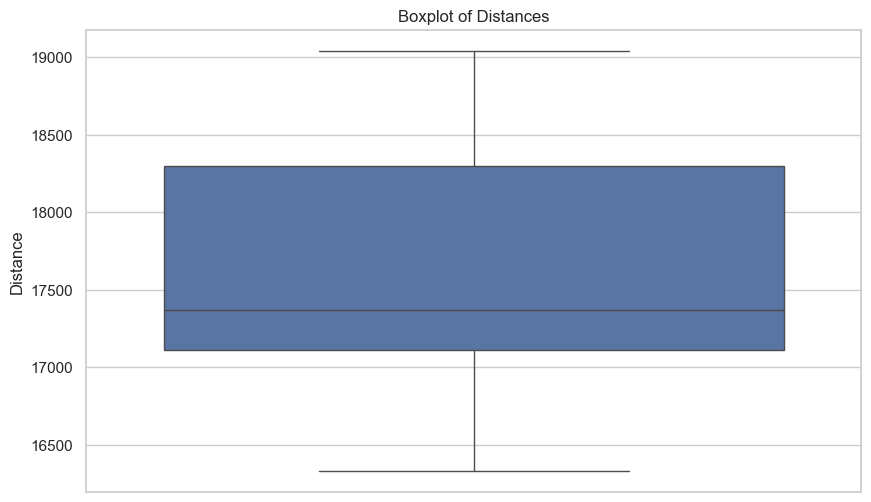

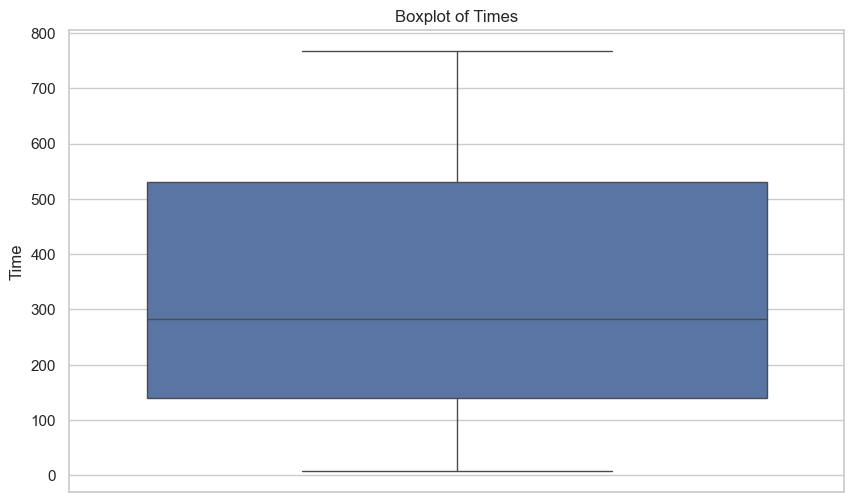

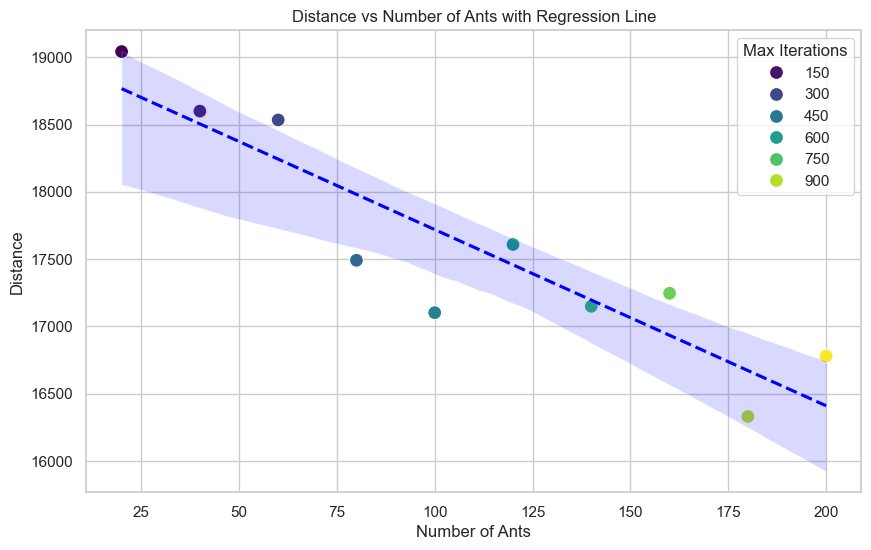

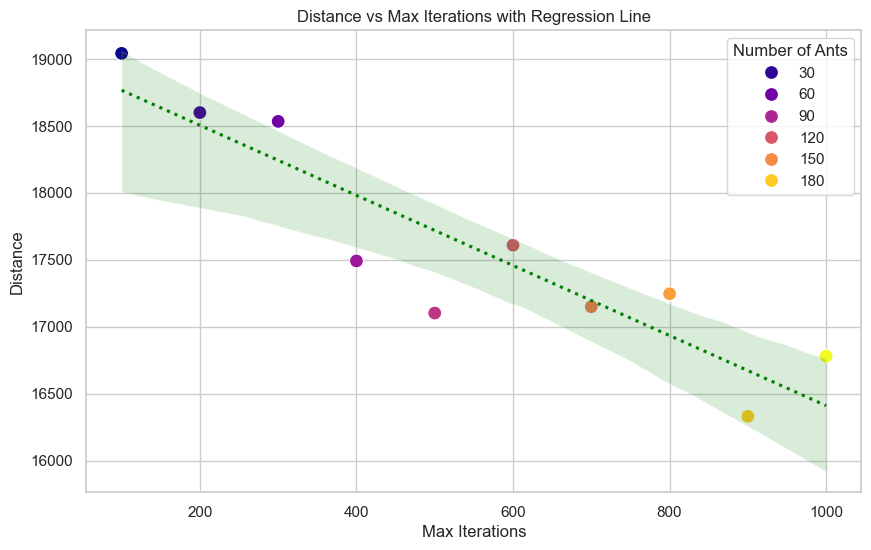

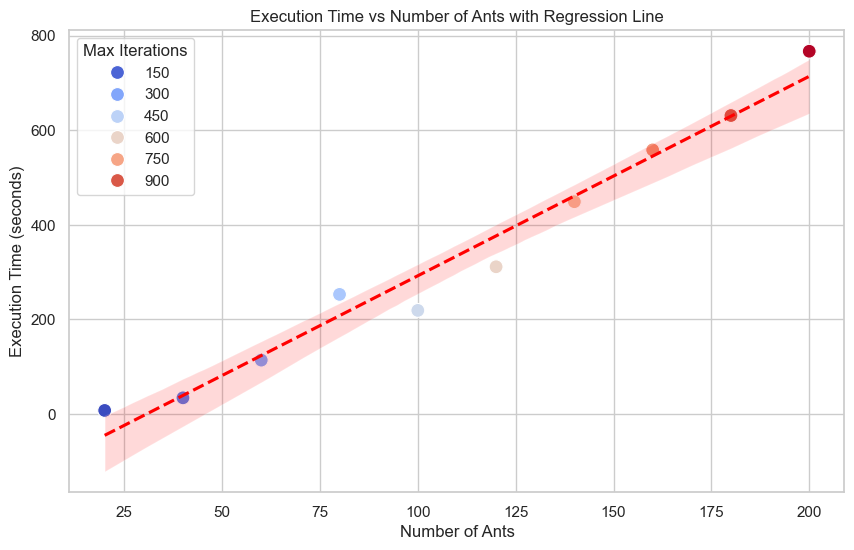

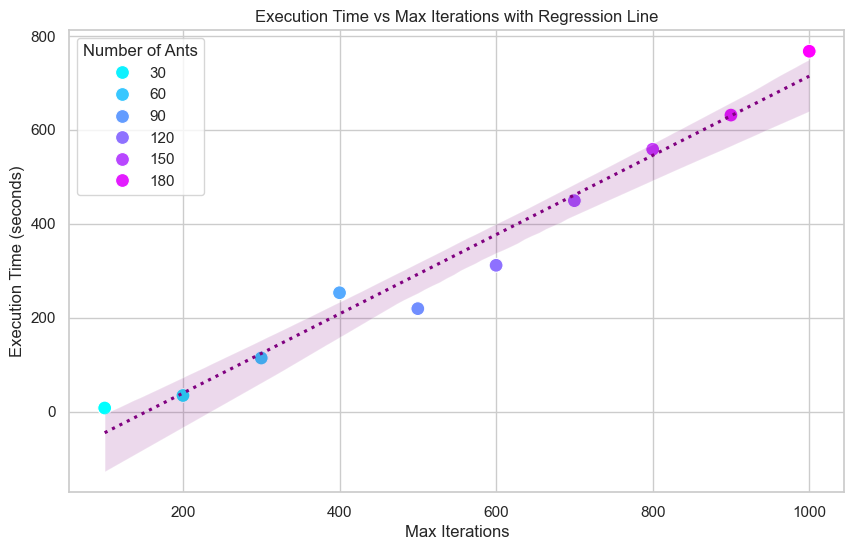

In [12]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON data from the file
with open("result_fourmi.json", "r") as file:
    data = json.load(file)

# Initialize a list to store the results
results = []

# Iterate through the tests in the JSON
for test_name, test_data in data.items():
    test_number = re.search(r'\d+', test_name).group()  # Extract the test number
    
    # Iterate through each parameter configuration
    for param_desc, values in test_data.items():
        # Extract the parameters (number of ants and iterations)
        match = re.search(r"ANT : number of ants, (\d+) ; maximum iteration, (\d+)", param_desc)
        if match:
            ants = int(match.group(1))
            max_iterations = int(match.group(2))
        else:
            ants = None
            max_iterations = None
        
        # Check if values is a list or dictionary
        if isinstance(values, list):
            # Iterate through each element in the list if values is a list
            for item in values:
                if isinstance(item, dict):
                    # Check for the presence of Distance and Time fields
                    distance = item.get("Distance")
                    time = item.get("Temps")
                    if distance is not None and time is not None:
                        results.append({
                            "TestNumber": int(test_number),
                            "Ants": ants,
                            "MaxIterations": max_iterations,
                            "Distance": distance,
                            "Time": time
                        })
                    else:
                        print(f"Warning: Test {test_number} with parameters {ants}, {max_iterations} missing 'Distance' or 'Time'")
        elif isinstance(values, dict):
            # Check for Distance and Time directly if values is a dictionary
            distance = values.get("Distance")
            time = values.get("Temps")
            if distance is not None and time is not None:
                results.append({
                    "TestNumber": int(test_number),
                    "Ants": ants,
                    "MaxIterations": max_iterations,
                    "Distance": distance,
                    "Time": time
                })
            else:
                print(f"Warning: Test {test_number} with parameters {ants}, {max_iterations} missing 'Distance' or 'Time'")

# Convert the results into a DataFrame for easier analysis
df = pd.DataFrame(results)
print(f"\nTotal number of tests extracted: {len(df)}")
pd.options.display.max_rows = 20  # Adjust to the size you want
print(df)  # Display a preview of the DataFrame

# Configure Seaborn style
sns.set(style="whitegrid")

# Boxplot for distances
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="Distance")
plt.title("Boxplot of Distances")
plt.ylabel("Distance")
plt.show()

# Boxplot for time
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="Time")
plt.title("Boxplot of Times")
plt.ylabel("Time")
plt.show()

# Scatter plot for distance based on the number of ants
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Ants", y="Distance", hue="MaxIterations", palette="viridis", s=100)
sns.regplot(data=df, x="Ants", y="Distance", scatter=False, color="blue", line_kws={"linestyle": "dashed"})
plt.title("Distance vs Number of Ants with Regression Line")
plt.xlabel("Number of Ants")
plt.ylabel("Distance")
plt.legend(title="Max Iterations")
plt.show()

# Scatter plot for distance based on max iterations
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="MaxIterations", y="Distance", hue="Ants", palette="plasma", s=100)
sns.regplot(data=df, x="MaxIterations", y="Distance", scatter=False, color="green", line_kws={"linestyle": "dotted"})
plt.title("Distance vs Max Iterations with Regression Line")
plt.xlabel("Max Iterations")
plt.ylabel("Distance")
plt.legend(title="Number of Ants")
plt.show()

# Scatter plot for execution time based on the number of ants
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Ants", y="Time", hue="MaxIterations", palette="coolwarm", s=100)
sns.regplot(data=df, x="Ants", y="Time", scatter=False, color="red", line_kws={"linestyle": "dashed"})
plt.title("Execution Time vs Number of Ants with Regression Line")
plt.xlabel("Number of Ants")
plt.ylabel("Execution Time (seconds)")
plt.legend(title="Max Iterations")
plt.show()

# Scatter plot for execution time based on max iterations
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="MaxIterations", y="Time", hue="Ants", palette="cool", s=100)
sns.regplot(data=df, x="MaxIterations", y="Time", scatter=False, color="purple", line_kws={"linestyle": "dotted"})
plt.title("Execution Time vs Max Iterations with Regression Line")
plt.xlabel("Max Iterations")
plt.ylabel("Execution Time (seconds)")
plt.legend(title="Number of Ants")
plt.show()


##### Statistiques pour l'algorithme de la recherche tabou


Total number of tests extracted: 10
   TestNumber  LengthTabu  MaxIterations  NumTests      Distance       Time
0           0          50             50       200  26183.370386   2.194299
1           1         100            100       400  24634.702714   3.961812
2           2         150            150       600  24963.099485   7.614108
3           3         200            200       800  23633.805217  12.042584
4           4         250            250      1000  24661.563412   9.634580
5           5         300            300      1200  23922.721827  10.898065
6           6         350            350      1400  24110.920621  12.874426
7           7         400            400      1600  24244.367412  16.582016
8           8         450            450      1800  23417.491689  23.238382
9           9         500            500      2000  23085.311770  19.053082


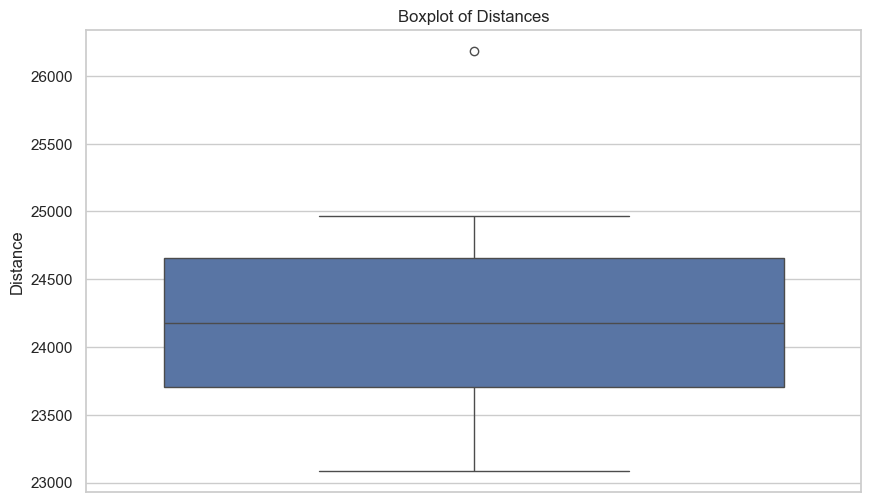

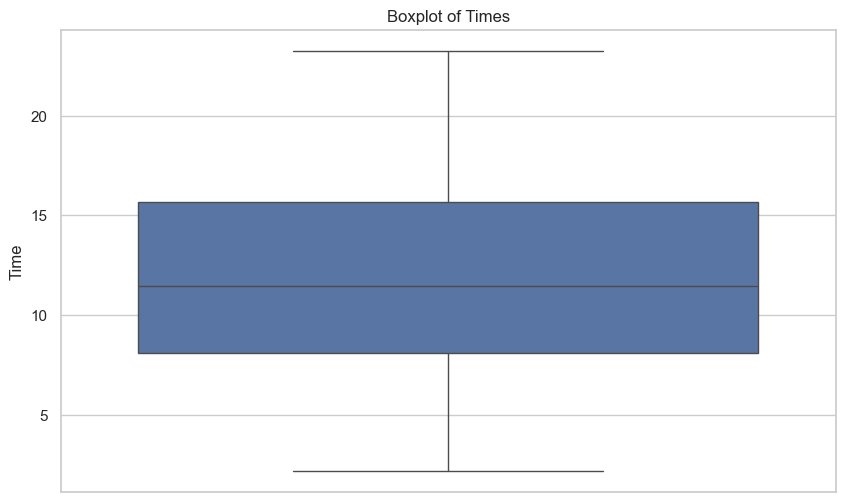

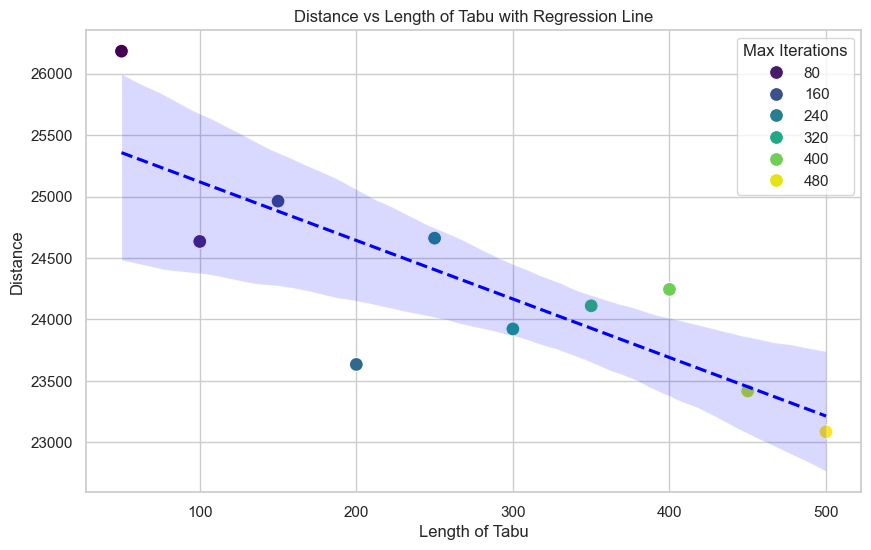

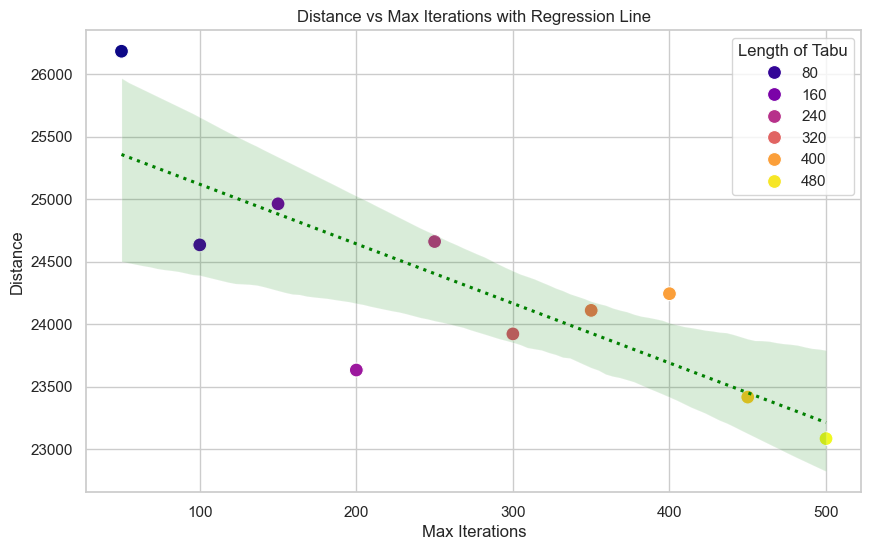

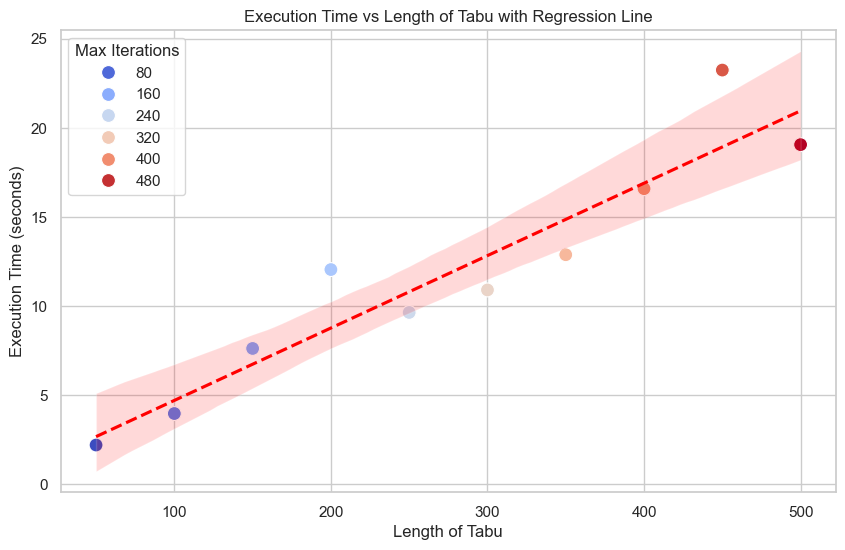

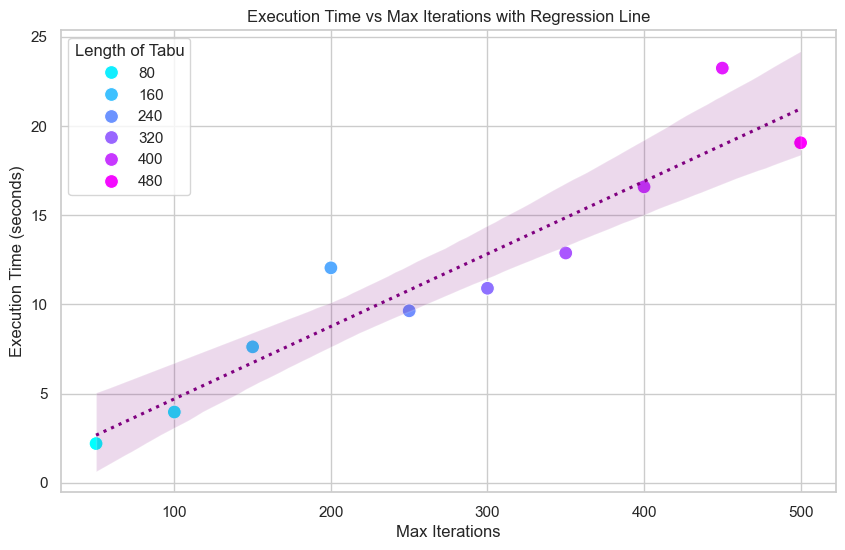

In [13]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON data from the file
with open("result_tabu.json", "r") as file:
    data = json.load(file)

# Initialize a list to store the results
results = []

# Iterate through the tests in the JSON
for test_name, test_data in data.items():
    test_number = re.search(r'\d+', test_name).group()  # Extract the test number
    
    # Iterate through each parameter configuration
    for param_desc, values in test_data.items():
        # Extract the parameters (length tabu, maximum iteration, etc.)
        match = re.search(r"Tabu : length tabu, (\d+) ; maximum iteration, (\d+) ; number of tests, (\d+)", param_desc)
        if match:
            length_tabu = int(match.group(1))
            max_iterations = int(match.group(2))
            num_tests = int(match.group(3))
        else:
            length_tabu = None
            max_iterations = None
            num_tests = None
        
        # Check if values is a list or dictionary
        if isinstance(values, list):
            # Iterate through each element in the list if values is a list
            for item in values:
                if isinstance(item, dict):
                    # Check for the presence of Distance and Time fields
                    distance = item.get("Distance")
                    time = item.get("Temps")
                    if distance is not None and time is not None:
                        results.append({
                            "TestNumber": int(test_number),
                            "LengthTabu": length_tabu,
                            "MaxIterations": max_iterations,
                            "NumTests": num_tests,
                            "Distance": distance,
                            "Time": time
                        })
                    else:
                        print(f"Warning: Test {test_number} with parameters {length_tabu}, {max_iterations}, {num_tests} missing 'Distance' or 'Time'")
        elif isinstance(values, dict):
            # Check for Distance and Time directly if values is a dictionary
            distance = values.get("Distance")
            time = values.get("Temps")
            if distance is not None and time is not None:
                results.append({
                    "TestNumber": int(test_number),
                    "LengthTabu": length_tabu,
                    "MaxIterations": max_iterations,
                    "NumTests": num_tests,
                    "Distance": distance,
                    "Time": time
                })
            else:
                print(f"Warning: Test {test_number} with parameters {length_tabu}, {max_iterations}, {num_tests} missing 'Distance' or 'Time'")

# Convert the results into a DataFrame for easier analysis
df = pd.DataFrame(results)
print(f"\nTotal number of tests extracted: {len(df)}")
pd.options.display.max_rows = 20  # Adjust to the size you want
print(df)  # Display a preview of the DataFrame

# Configure Seaborn style
sns.set(style="whitegrid")

# Boxplot for distances
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="Distance")
plt.title("Boxplot of Distances")
plt.ylabel("Distance")
plt.show()

# Boxplot for time
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="Time")
plt.title("Boxplot of Times")
plt.ylabel("Time")
plt.show()

# Scatter plot for distance based on length tabu
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="LengthTabu", y="Distance", hue="MaxIterations", palette="viridis", s=100)
sns.regplot(data=df, x="LengthTabu", y="Distance", scatter=False, color="blue", line_kws={"linestyle": "dashed"})
plt.title("Distance vs Length of Tabu with Regression Line")
plt.xlabel("Length of Tabu")
plt.ylabel("Distance")
plt.legend(title="Max Iterations")
plt.show()

# Scatter plot for distance based on max iterations
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="MaxIterations", y="Distance", hue="LengthTabu", palette="plasma", s=100)
sns.regplot(data=df, x="MaxIterations", y="Distance", scatter=False, color="green", line_kws={"linestyle": "dotted"})
plt.title("Distance vs Max Iterations with Regression Line")
plt.xlabel("Max Iterations")
plt.ylabel("Distance")
plt.legend(title="Length of Tabu")
plt.show()

# Scatter plot for time based on length tabu
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="LengthTabu", y="Time", hue="MaxIterations", palette="coolwarm", s=100)
sns.regplot(data=df, x="LengthTabu", y="Time", scatter=False, color="red", line_kws={"linestyle": "dashed"})
plt.title("Execution Time vs Length of Tabu with Regression Line")
plt.xlabel("Length of Tabu")
plt.ylabel("Execution Time (seconds)")
plt.legend(title="Max Iterations")
plt.show()

# Scatter plot for time based on max iterations
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="MaxIterations", y="Time", hue="LengthTabu", palette="cool", s=100)
sns.regplot(data=df, x="MaxIterations", y="Time", scatter=False, color="purple", line_kws={"linestyle": "dotted"})
plt.title("Execution Time vs Max Iterations with Regression Line")
plt.xlabel("Max Iterations")
plt.ylabel("Execution Time (seconds)")
plt.legend(title="Length of Tabu")
plt.show()


##### Statistiques pour l'algorithme génétique


Total number of tests extracted: 10
   TestNumber  Generations  PopulationSize  MutationRate     Distance  \
0           0          700             200           0.3  2923.719412   
1           1         1000             350           0.6  2926.186287   
2           2         1300             500           0.9  3044.959619   
3           3         1600             650           1.2  3142.358928   
4           4         1900             800           1.5  2992.184842   
5           5         2200             950           1.8  3011.506329   
6           6         2500            1100           2.1  2818.614519   
7           7         2800            1250           2.4  2989.807886   
8           8         3100            1400           2.7  2469.564013   
9           9         3400            1550           3.0  2913.044271   

         Time  
0    1.494659  
1    6.135163  
2   10.122205  
3   10.865699  
4   23.327295  
5   28.033966  
6   25.436634  
7  124.967057  
8   85.329301  

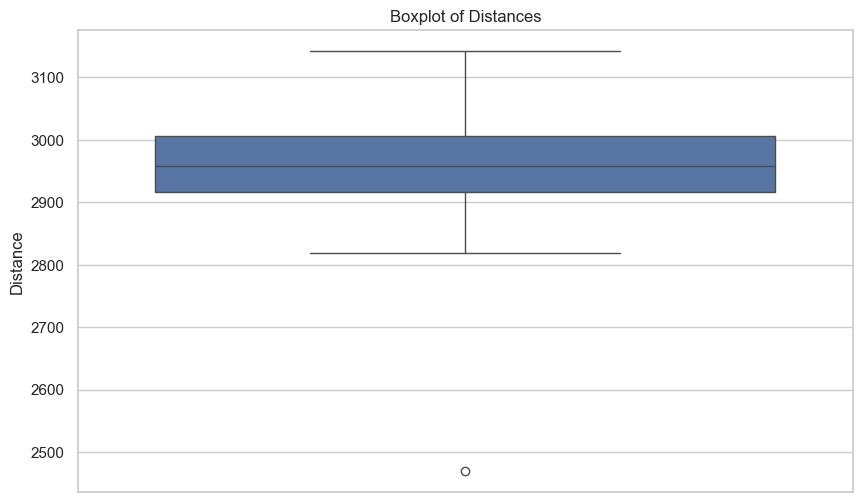

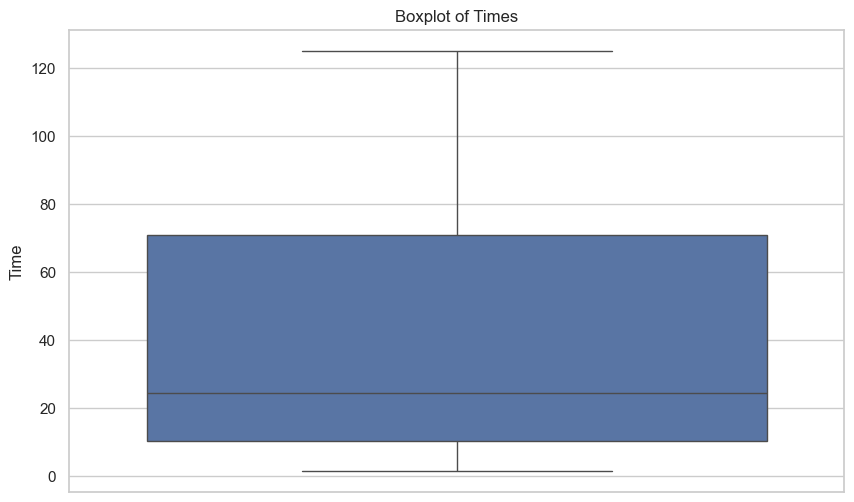

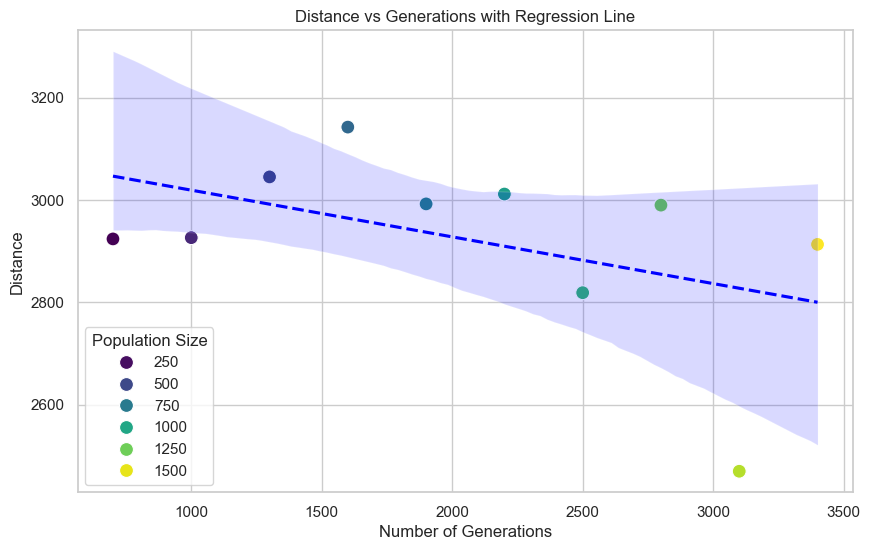

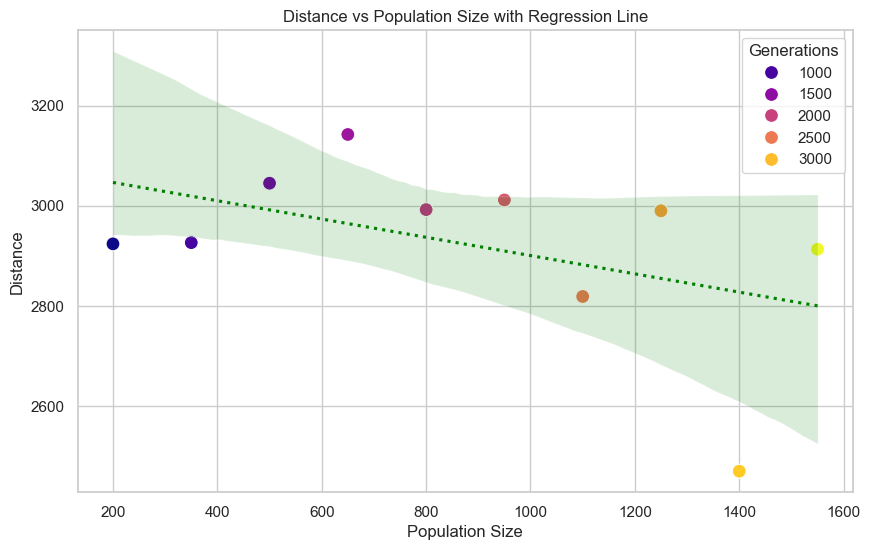

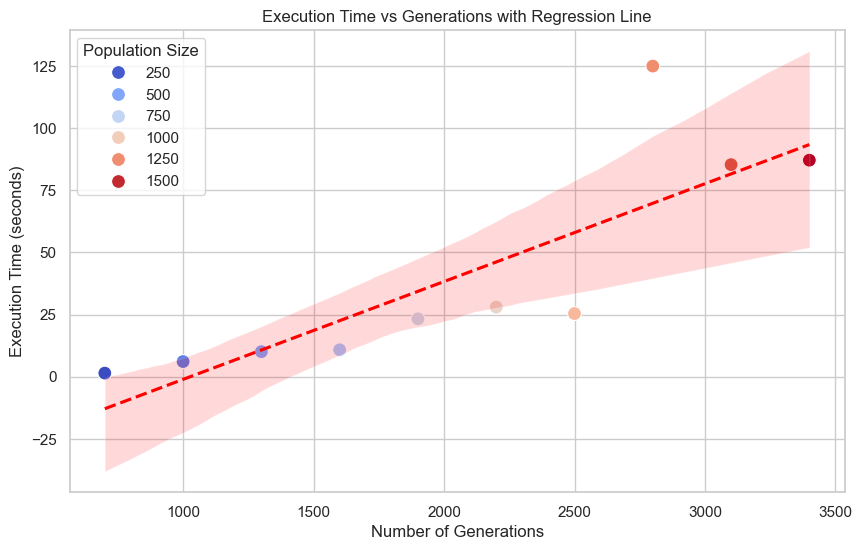

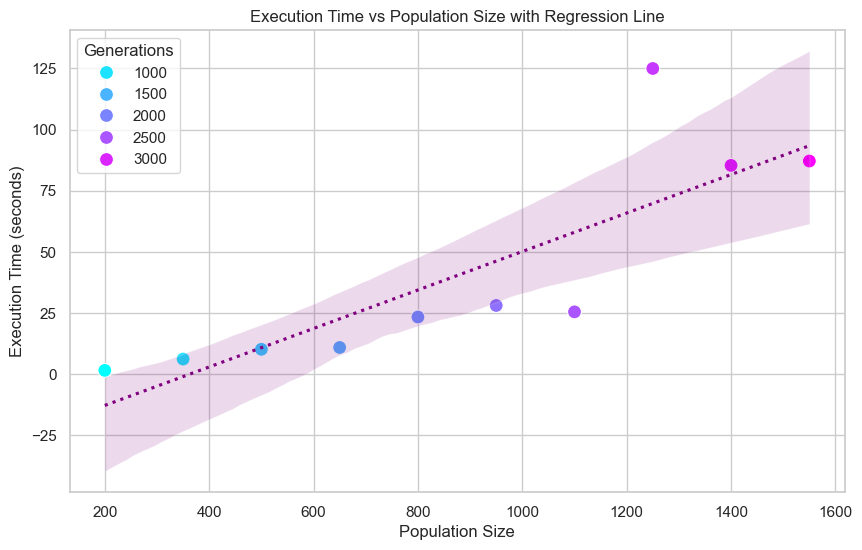

In [14]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON data from the file
with open("result_genetics.json", "r") as file:
    data = json.load(file)

# Initialize a list to store the results
results = []

# Iterate through the tests in the JSON
for test_name, test_data in data.items():
    test_number = re.search(r'\d+', test_name).group()  # Extract the test number
    
    # Iterate through each parameter configuration
    for param_desc, values in test_data.items():
        # Extract the parameters for Tabu, Genetics, etc.
        match_genetics = re.search(r"Genetics : generations, (\d+) ; population size, (\d+) ; mutation rate, (\d+\.\d+)", param_desc)
        
        if match_genetics:
            generations = int(match_genetics.group(1))
            population_size = int(match_genetics.group(2))
            mutation_rate = float(match_genetics.group(3))
        else:
            generations, population_size, mutation_rate = None, None, None
        
        # Check if values is a list or dictionary
        if isinstance(values, list):
            # Iterate through each element in the list if values is a list
            for item in values:
                if isinstance(item, dict):
                    # Check for the presence of Distance and Time fields
                    distance = item.get("Distance")
                    time = item.get("Temps")
                    if distance is not None and time is not None:
                        results.append({
                            "TestNumber": int(test_number),
                            "Generations": generations,
                            "PopulationSize": population_size,
                            "MutationRate": mutation_rate,
                            "Distance": distance,
                            "Time": time
                        })
                    else:
                        print(f"Warning: Test {test_number} with parameters {generations}, {population_size}, {mutation_rate} missing 'Distance' or 'Time'")
        elif isinstance(values, dict):
            # Check for Distance and Time directly if values is a dictionary
            distance = values.get("Distance")
            time = values.get("Temps")
            if distance is not None and time is not None:
                results.append({
                    "TestNumber": int(test_number),
                    "Generations": generations,
                    "PopulationSize": population_size,
                    "MutationRate": mutation_rate,
                    "Distance": distance,
                    "Time": time
                })
            else:
                print(f"Warning: Test {test_number} with parameters {generations}, {population_size}, {mutation_rate} missing 'Distance' or 'Time'")

# Convert the results into a DataFrame for easier analysis
df = pd.DataFrame(results)
print(f"\nTotal number of tests extracted: {len(df)}")
pd.options.display.max_rows = 20  # Adjust to the size you want
print(df)  # Display a preview of the DataFrame

# Configure Seaborn style
sns.set(style="whitegrid")

# Boxplot for distances
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="Distance")
plt.title("Boxplot of Distances")
plt.ylabel("Distance")
plt.show()

# Boxplot for time
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y="Time")
plt.title("Boxplot of Times")
plt.ylabel("Time")
plt.show()

# Scatter plot for distance based on number of generations
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Generations", y="Distance", hue="PopulationSize", palette="viridis", s=100)
sns.regplot(data=df, x="Generations", y="Distance", scatter=False, color="blue", line_kws={"linestyle": "dashed"})
plt.title("Distance vs Generations with Regression Line")
plt.xlabel("Number of Generations")
plt.ylabel("Distance")
plt.legend(title="Population Size")
plt.show()

# Scatter plot for distance based on population size
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="PopulationSize", y="Distance", hue="Generations", palette="plasma", s=100)
sns.regplot(data=df, x="PopulationSize", y="Distance", scatter=False, color="green", line_kws={"linestyle": "dotted"})
plt.title("Distance vs Population Size with Regression Line")
plt.xlabel("Population Size")
plt.ylabel("Distance")
plt.legend(title="Generations")
plt.show()

# Scatter plot for time based on number of generations
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Generations", y="Time", hue="PopulationSize", palette="coolwarm", s=100)
sns.regplot(data=df, x="Generations", y="Time", scatter=False, color="red", line_kws={"linestyle": "dashed"})
plt.title("Execution Time vs Generations with Regression Line")
plt.xlabel("Number of Generations")
plt.ylabel("Execution Time (seconds)")
plt.legend(title="Population Size")
plt.show()

# Scatter plot for time based on population size
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="PopulationSize", y="Time", hue="Generations", palette="cool", s=100)
sns.regplot(data=df, x="PopulationSize", y="Time", scatter=False, color="purple", line_kws={"linestyle": "dotted"})
plt.title("Execution Time vs Population Size with Regression Line")
plt.xlabel("Population Size")
plt.ylabel("Execution Time (seconds)")
plt.legend(title="Generations")
plt.show()


### <center>Pistes d'améliorations / Doutes </center>
Ci-dessous une liste d'idées pour améliorer cette modélisation, mais surtout sur des doutes qui créent des questions à poser. </br>
* Ajouter pour les volumes de la demande client une modélisation qui correspond au total des objets __n__ avec chacun leur poids et volume. </br>
* Au niveau du remplissage des camions, est ce que l'on charge tout dès le départ, donc il fait sa tournée selon sa capacité ou alors il peut déposer des objets puis en récupére à des points de collecte pour se reremplir et donc prendre théoriquement plus que sa capacité sur la tournée totale. </br>
### <center>Annexe </center>
Ci-dessous le lien de notre dépôt git : </br>
- https://github.com/FRAIOLIenzo/Truck-Quillite.git